In [387]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
import keras 
import matplotlib.pyplot as plt 
import cv2 
import os
import numpy as np

In [388]:
batch_size = 10
height = 224
width = 224

In [389]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
   'Data/train2',
   shuffle=True,
   image_size = (height, width),
   batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
   'Data/train2',
   shuffle=True,
   image_size = (height, width),
   batch_size=batch_size
)

Found 83 files belonging to 2 classes.
Found 83 files belonging to 2 classes.


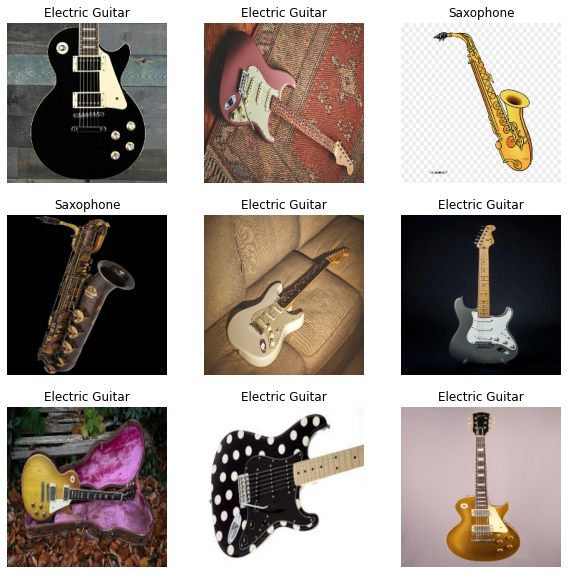

In [390]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [391]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)


In [392]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 5
Number of test batches: 4


In [393]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [394]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


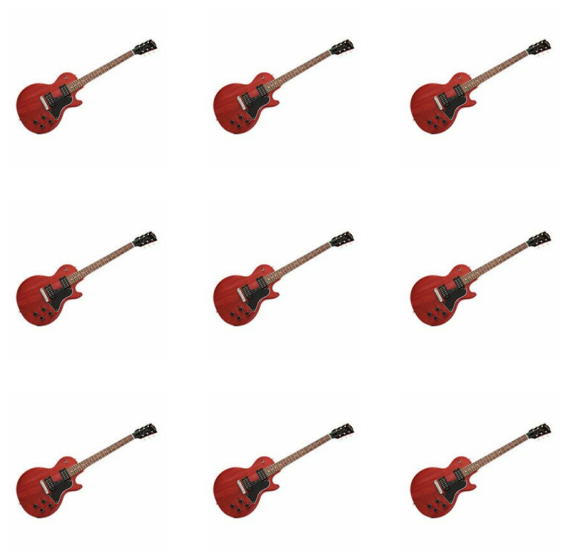

In [395]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [396]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [397]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [398]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(10, 7, 7, 1280)


In [399]:
#Feature Extraction
base_model.trainable = False


In [400]:
# Let's take a look at the base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_23[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [401]:
#add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(10, 1280)


In [402]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(10, 1)


In [403]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [404]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [405]:
model.summary()


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_11 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_11 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_11 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                          

In [406]:
len(model.trainable_variables)


2

In [407]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


5/5 [==============================] - 3s 129ms/step - loss: 0.6792 - accuracy: 0.6512


In [408]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.68
initial accuracy: 0.65


In [409]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
9/9 [==============================] - 7s 336ms/step - loss: 0.6635 - accuracy: 0.6747 - val_loss: 0.6009 - val_accuracy: 0.6977
Epoch 2/10
9/9 [==============================] - 4s 338ms/step - loss: 0.6383 - accuracy: 0.6506 - val_loss: 0.5959 - val_accuracy: 0.6512
Epoch 3/10
9/9 [==============================] - 4s 329ms/step - loss: 0.6361 - accuracy: 0.6506 - val_loss: 0.5498 - val_accuracy: 0.6512
Epoch 4/10
9/9 [==============================] - 4s 333ms/step - loss: 0.5385 - accuracy: 0.6747 - val_loss: 0.5301 - val_accuracy: 0.6744
Epoch 5/10
9/9 [==============================] - 4s 360ms/step - loss: 0.5360 - accuracy: 0.6627 - val_loss: 0.5299 - val_accuracy: 0.6047
Epoch 6/10
9/9 [==============================] - 4s 351ms/step - loss: 0.4999 - accuracy: 0.6627 - val_loss: 0.4885 - val_accuracy: 0.6512
Epoch 7/10
9/9 [==============================] - 4s 354ms/step - loss: 0.4727 - accuracy: 0.6988 - val_loss: 0.4331 - val_accuracy: 0.6512
Epoch 8/10
9/9 [====

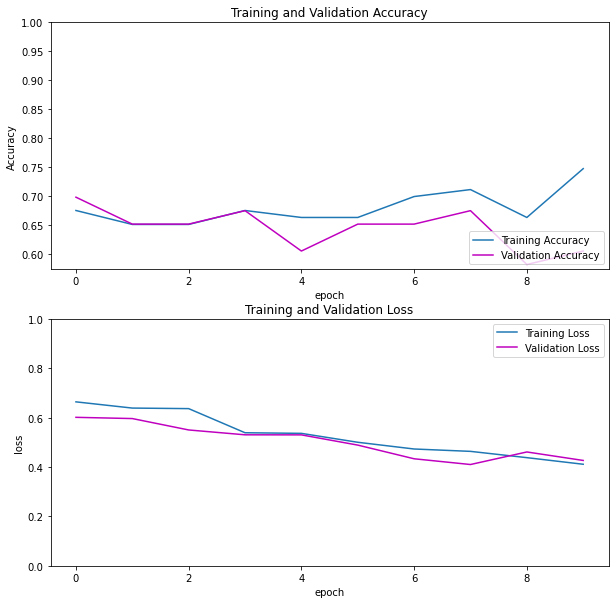

In [410]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy', color='m')
plt.xlabel("epoch")
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', color='m')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [411]:
loss1, accuracy1 = model.evaluate(test_dataset)
print(accuracy1)

4/4 [==============================] - 1s 147ms/step - loss: 0.3778 - accuracy: 0.7000
0.699999988079071


In [412]:
#fine tuning
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [413]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_11 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_11 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_11 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                          

In [414]:
len(model.trainable_variables)

56

In [415]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
9/9 [==============================] - 11s 553ms/step - loss: 0.2461 - accuracy: 0.8795 - val_loss: 0.1337 - val_accuracy: 0.9535
Epoch 11/20
9/9 [==============================] - 5s 418ms/step - loss: 0.1248 - accuracy: 0.9277 - val_loss: 0.0635 - val_accuracy: 1.0000
Epoch 12/20
9/9 [==============================] - 5s 414ms/step - loss: 0.0714 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 1.0000
Epoch 13/20
9/9 [==============================] - 5s 412ms/step - loss: 0.0346 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 1.0000
Epoch 14/20
9/9 [==============================] - 6s 528ms/step - loss: 0.0215 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 15/20
9/9 [==============================] - 5s 426ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 16/20
9/9 [==============================] - 5s 419ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 17/20


In [416]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


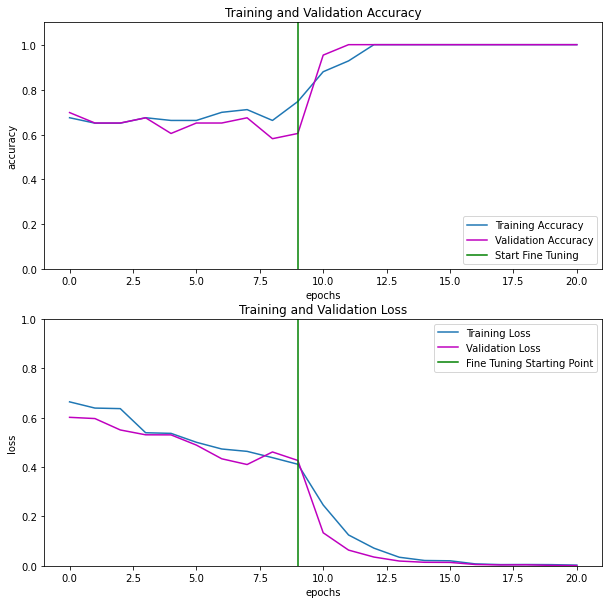

In [417]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy', color='m')
plt.ylim([0.0, 1.1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning', color='g')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', color='m')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Fine Tuning Starting Point', color='g')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [418]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


4/4 [==============================] - 1s 156ms/step - loss: 0.0011 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [0 0 1 1 0 1 0 0 1 1]
Labels:
 [0 0 1 1 0 1 0 0 1 1]


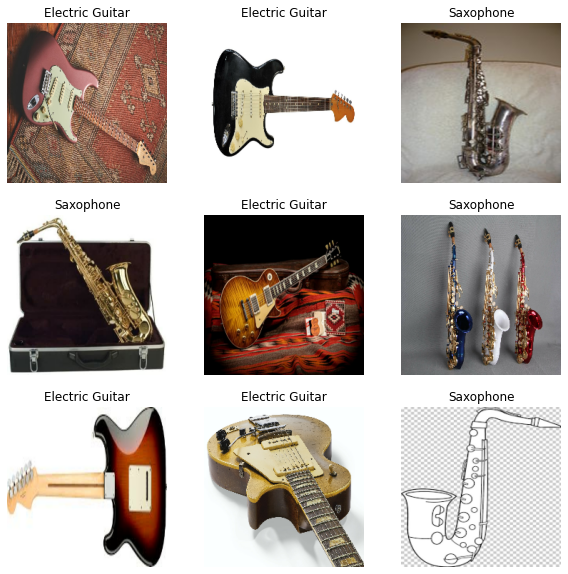

In [419]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [420]:
from pathlib import Path
import imghdr

data_dir = "Data/train2"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")